In [1]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
from torchvision.models import ResNet18_Weights, VGG16_Weights, Inception_V3_Weights, DenseNet161_Weights
import matplotlib.pyplot as plt

/home/superadmin/workspace/DR-TANet/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/superadmin/workspace/DR-TANet/venv/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [15]:
def train_inception(net, train_iter, test_iter, trainer, num_epochs, losses_list):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat.logits, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.logits.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
              losses_list.append((i, train_l_sum / n))
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [16]:
def train(net, train_iter, test_iter, trainer, num_epochs, losses_list):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
              losses_list.append((i, train_l_sum / n))
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [17]:
BATCH_SIZE = 256

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', train=True, split="balanced", transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', train=False, split="balanced", transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [18]:
model = tv.models.resnet18(weights=ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=512, out_features=47)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
trainer = torch.optim.Adam(params_to_update, lr=0.001)
resnet18_loss = []

In [19]:
train(model, train_iter, test_iter, trainer, 1, resnet18_loss)

Step 0. time since epoch: 0.184. Train acc: 0.020. Train Loss: 4.088
Step 10. time since epoch: 1.988. Train acc: 0.064. Train Loss: 3.791
Step 20. time since epoch: 3.812. Train acc: 0.146. Train Loss: 3.558
Step 30. time since epoch: 5.650. Train acc: 0.215. Train Loss: 3.346
Step 40. time since epoch: 7.454. Train acc: 0.270. Train Loss: 3.171
Step 50. time since epoch: 9.269. Train acc: 0.315. Train Loss: 3.016
Step 60. time since epoch: 11.088. Train acc: 0.349. Train Loss: 2.883
Step 70. time since epoch: 12.913. Train acc: 0.382. Train Loss: 2.759
Step 80. time since epoch: 14.722. Train acc: 0.409. Train Loss: 2.651
Step 90. time since epoch: 16.520. Train acc: 0.433. Train Loss: 2.551
Step 100. time since epoch: 18.336. Train acc: 0.454. Train Loss: 2.465
Step 110. time since epoch: 20.150. Train acc: 0.471. Train Loss: 2.388
Step 120. time since epoch: 21.956. Train acc: 0.485. Train Loss: 2.318
Step 130. time since epoch: 23.777. Train acc: 0.498. Train Loss: 2.255
Step 140.

In [20]:
model = tv.models.vgg16(weights=VGG16_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(in_features=4096, out_features=47)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
trainer = torch.optim.Adam(params_to_update, lr=0.001)
vgg16_loss = []

In [21]:
train(model, train_iter, test_iter, trainer, 1, vgg16_loss)

Step 0. time since epoch: 0.664. Train acc: 0.027. Train Loss: 3.873
Step 10. time since epoch: 5.601. Train acc: 0.113. Train Loss: 3.535
Step 20. time since epoch: 10.568. Train acc: 0.197. Train Loss: 3.236
Step 30. time since epoch: 15.559. Train acc: 0.259. Train Loss: 2.992
Step 40. time since epoch: 20.511. Train acc: 0.297. Train Loss: 2.826
Step 50. time since epoch: 25.488. Train acc: 0.329. Train Loss: 2.686
Step 60. time since epoch: 30.486. Train acc: 0.350. Train Loss: 2.580
Step 70. time since epoch: 35.429. Train acc: 0.370. Train Loss: 2.485
Step 80. time since epoch: 40.394. Train acc: 0.387. Train Loss: 2.405
Step 90. time since epoch: 45.361. Train acc: 0.403. Train Loss: 2.333
Step 100. time since epoch: 50.325. Train acc: 0.418. Train Loss: 2.271
Step 110. time since epoch: 55.318. Train acc: 0.428. Train Loss: 2.218
Step 120. time since epoch: 60.297. Train acc: 0.438. Train Loss: 2.170
Step 130. time since epoch: 65.314. Train acc: 0.446. Train Loss: 2.130
Step 

In [6]:
model = tv.models.inception_v3(weights=Inception_V3_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=2048, out_features=47)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
trainer = torch.optim.Adam(params_to_update, lr=0.001)
inception3_loss = []

In [7]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', train=True, split="balanced", transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', train=False, split="balanced", transform=transoforms, download=True)
train_iter_inc3 = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter_inc3 = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [12]:
train(model, train_iter_inc3, test_iter_inc3, trainer, 1, inception3_loss)

Step 0. time since epoch: 0.473. Train acc: 0.047. Train Loss: 3.711
Step 10. time since epoch: 5.067. Train acc: 0.068. Train Loss: 3.747
Step 20. time since epoch: 9.562. Train acc: 0.122. Train Loss: 3.599
Step 30. time since epoch: 14.143. Train acc: 0.168. Train Loss: 3.460
Step 40. time since epoch: 18.644. Train acc: 0.203. Train Loss: 3.344
Step 50. time since epoch: 23.167. Train acc: 0.232. Train Loss: 3.240
Step 60. time since epoch: 27.713. Train acc: 0.257. Train Loss: 3.148
Step 70. time since epoch: 32.216. Train acc: 0.278. Train Loss: 3.065
Step 80. time since epoch: 36.799. Train acc: 0.295. Train Loss: 2.985
Step 90. time since epoch: 41.296. Train acc: 0.312. Train Loss: 2.912
Step 100. time since epoch: 45.806. Train acc: 0.327. Train Loss: 2.847
Step 110. time since epoch: 50.329. Train acc: 0.339. Train Loss: 2.788
Step 120. time since epoch: 54.872. Train acc: 0.349. Train Loss: 2.735
Step 130. time since epoch: 59.397. Train acc: 0.359. Train Loss: 2.685
Step 1

In [22]:
model = tv.models.densenet161(weights=DenseNet161_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Linear(in_features=2208, out_features=47)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
trainer = torch.optim.Adam(params_to_update, lr=0.001)
densenet161_loss = []

In [23]:
train(model, train_iter, test_iter, trainer, 1, densenet161_loss)

Step 0. time since epoch: 0.620. Train acc: 0.027. Train Loss: 3.904
Step 10. time since epoch: 6.839. Train acc: 0.128. Train Loss: 3.622
Step 20. time since epoch: 13.045. Train acc: 0.220. Train Loss: 3.363
Step 30. time since epoch: 19.260. Train acc: 0.288. Train Loss: 3.138
Step 40. time since epoch: 25.474. Train acc: 0.335. Train Loss: 2.961
Step 50. time since epoch: 31.688. Train acc: 0.375. Train Loss: 2.805
Step 60. time since epoch: 37.909. Train acc: 0.400. Train Loss: 2.679
Step 70. time since epoch: 44.129. Train acc: 0.425. Train Loss: 2.566
Step 80. time since epoch: 50.358. Train acc: 0.446. Train Loss: 2.466
Step 90. time since epoch: 56.595. Train acc: 0.466. Train Loss: 2.376
Step 100. time since epoch: 62.843. Train acc: 0.484. Train Loss: 2.296
Step 110. time since epoch: 69.086. Train acc: 0.499. Train Loss: 2.223
Step 120. time since epoch: 75.323. Train acc: 0.511. Train Loss: 2.160
Step 130. time since epoch: 81.557. Train acc: 0.523. Train Loss: 2.103
Step 

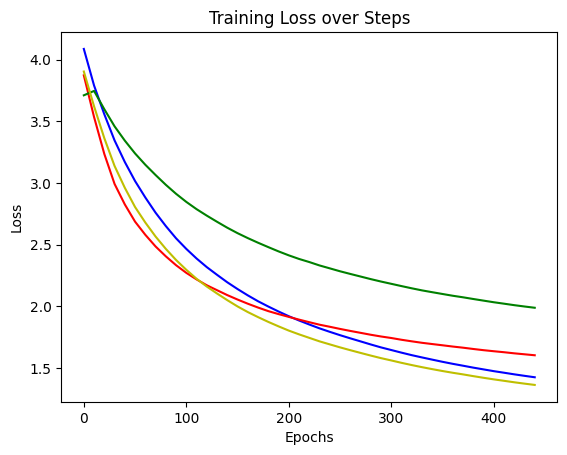

In [24]:
plt.figure()

steps = [data[0] for data in resnet18_loss]
loss = [data[1] for data in resnet18_loss]
plt.plot(steps, loss, 'b', label='resnet18_loss')

steps = [data[0] for data in vgg16_loss]
loss = [data[1] for data in vgg16_loss]
plt.plot(steps, loss, 'r', label='vgg16_loss')

steps = [data[0] for data in inception3_loss]
loss = [data[1] for data in inception3_loss]
plt.plot(steps, loss, 'g', label='inception3_loss')

steps = [data[0] for data in densenet161_loss]
loss = [data[1] for data in densenet161_loss]
plt.plot(steps, loss, 'y', label='densenet161_loss')

plt.title('Training Loss over Steps')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.show()

## Итоги

- Inception обучалается медленее всего (при этом в самом начале обучения ее ошибка росла).
- VGG16 сначала разогланалась сильнее других, но к концу эпохи замедлилась.
- Densenet161 на конец эпохи имеет самую низкую ошибку.
- Resnet18 на фоне других на протяжении первой эпохи ничем не примечательна.